In [1]:
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import loguniform
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix,
    PrecisionRecallDisplay, roc_curve, roc_auc_score
)
from sklearn.model_selection import (
    cross_validate, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder
)
from sklearn.model_selection import cross_val_predict

In [2]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
# Read Data
train_df = pd.read_csv("../data/preprocessed/clean_train.csv")
test_df = pd.read_csv("../data/preprocessed/clean_test.csv")


# Transform native_country into binary
train_df['native_country'] = train_df['native_country'] == 'United-States'
test_df['native_country'] = test_df['native_country'] == 'United-States'

# Set positive label to ">50K", which is the class with smaller proportion
train_df['income'] = train_df['income'] == '>50K'
test_df['income'] = test_df['income'] == '>50K'

In [4]:
# Split data into features & target
X_train = train_df.drop("income", axis=1)
y_train = train_df['income']
X_test = test_df.drop("income", axis=1)
y_test = test_df['income']

In [5]:
# Preprocessing
numeric_feats = ['age', 'fnlwgt', 'hours_per_week']
categorical_null_feats = ['workclass', "occupation"]
categorical_nonull_feats = ["marital_status", "relationship"]

binary_feats = ['sex', 'native_country']
passthrough_feats = ['education_num']
drop_feats = ['education', 'race', 'capital_gain', 'capital_loss']

col_trans = make_column_transformer(
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore', drop=[np.nan] * 2), categorical_null_feats),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_nonull_feats),
    (OneHotEncoder(drop='if_binary'), binary_feats),
    ('passthrough', passthrough_feats),
    ('drop', drop_feats)
)

In [6]:
# Calculate Baseline Performances
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = {}
pipe_dummy = make_pipeline(
    col_trans,
    DummyClassifier()
)
results['DummyClassifier'] = pd.DataFrame(cross_validate(pipe_dummy, X_train, y_train, scoring=scoring)).mean()

# Calculate Baseline Perfromance for Random Forest Classifier
pipe_forest = make_pipeline(
    col_trans,
    RandomForestClassifier(random_state=522)
)
results['RandomForest_default'] = pd.DataFrame(cross_validate(pipe_forest, X_train, y_train, scoring=scoring)).mean()

/Users/sukhleen/opt/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sukhleen/opt/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sukhleen/opt/miniconda3/envs/census-income/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sukhle

In [7]:
pd.DataFrame(results)

,DummyClassifier,RandomForest_default
fit_time,0.039792,1.656685
score_time,0.015624,0.112002
test_accuracy,0.759190,0.827278
test_precision,0.000000,0.667138
test_recall,0.000000,0.564342
test_f1,0.000000,0.611435


In [8]:
param_dist = {
    "randomforestclassifier__class_weight": [None, "balanced"],
    "randomforestclassifier__n_estimators": [10, 20, 50, 100, 200, 500],
    "randomforestclassifier__max_depth": np.arange(10, 20, 2)
}
rand_search_rf = RandomizedSearchCV(pipe_forest, param_dist, n_iter=20, 
                                    random_state=952, scoring=scoring, refit="f1")

rand_search_rf.fit(X_train, y_train);

In [9]:
hyperparam_result = pd.DataFrame(
    rand_search_rf.cv_results_
).sort_values("rank_test_f1")[['param_randomforestclassifier__n_estimators',
                                     'param_randomforestclassifier__max_depth',
                                     'param_randomforestclassifier__class_weight',
                                     'mean_test_accuracy',
                                     'mean_test_precision',
                                     'mean_test_recall',
                                     'mean_test_f1',
                                    ]]
hyperparam_result

,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,param_randomforestclassifier__class_weight,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
10,200,16,balanced,0.811461,0.580237,0.784975,0.667217
18,20,16,balanced,0.810571,0.578688,0.784721,0.666094
16,100,18,balanced,0.816345,0.593162,0.755643,0.664572
3,200,12,balanced,0.795062,0.548921,0.835863,0.662660
11,50,12,balanced,0.795123,0.549109,0.834715,0.662420
6,20,12,balanced,0.795584,0.550227,0.828466,0.661240
7,10,18,balanced,0.811308,0.585185,0.744292,0.655167
14,50,10,balanced,0.780781,0.527664,0.856905,0.653112
1,50,18,None,0.840023,0.712278,0.563831,0.629317
15,500,18,None,0.840331,0.714309,0.562046,0.629031


In [10]:
# Evaluate Model with test data set
y_pred_train = rand_search_rf.predict(X_train)
y_pred = rand_search_rf.predict(X_test)

In [11]:
# Table of Metrics for positive class for train and test set
model_perf_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)],
        "Precision": [precision_score(y_train, y_pred_train), precision_score(y_test, y_pred)],
        "Recall": [recall_score(y_train, y_pred_train), recall_score(y_test, y_pred)],
        "F1 Score": [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred)]
    },
    index=["Train Data", "Test Data"])
model_perf_df

,Accuracy,Precision,Recall,F1 Score
Train Data,0.868493,0.660388,0.934447,0.773870
Test Data,0.810577,0.571751,0.789392,0.663172


In [12]:
# Confusion Matrix for the test set

test_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, cross_val_predict(pipe_forest, X_test, y_test)),
            columns = ['Predicted negative (0)', 'Predicted positive (1)'],
            index = ['True negative (0)', 'True positive (1)'])
test_confusion_matrix

,Predicted negative (0),Predicted positive (1)
True negative (0),11393,1042
True positive (1),1715,2131


In [13]:
# Classification report for test set

pipe_forest.fit(X_train, y_train)

y_pred = pipe_forest.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["negative (0)", "positive (1)"], output_dict=True)
classification_report = pd.DataFrame(report).transpose()

In [14]:
# Table of Metrics for train set

PR_curve_df = pd.DataFrame(precision_recall_curve(y_train, rand_search_rf.predict_proba(X_train)[:,1],), index=["precision","recall","threshold"]).T
PR_curve_df['F1 Score'] =  2 * (PR_curve_df['precision'] * PR_curve_df['recall'])/(PR_curve_df['precision'] + PR_curve_df['recall'])
PR_curve_df

,precision,recall,threshold,F1 Score
0,0.449702,1.000000,0.155372,0.620406
1,0.449670,0.999872,0.155387,0.620351
2,0.449696,0.999872,0.155421,0.620376
3,0.449722,0.999872,0.155487,0.620400
4,0.449748,0.999872,0.155577,0.620425
...,...,...,...,...
17276,1.000000,0.000510,0.976791,0.001020
17277,1.000000,0.000383,0.977144,0.000765
17278,1.000000,0.000255,0.977213,0.000510
17279,1.000000,0.000128,0.978738,0.000255


In [15]:
# Average precision score for test set

ap_forest = average_precision_score(y_test, pipe_forest.predict_proba(X_test)[:, 1])
print("Average precision of Random Forest Classifier: {:.3f}".format(ap_forest))

Average precision of Random Forest Classifier: 0.665


In [16]:
# Threshold to get best F1 score
max_f1_df = PR_curve_df.iloc[PR_curve_df["F1 Score"].idxmax()].to_frame().T
best_thres = max_f1_df['threshold'].iloc[0]
max_f1_df

,precision,recall,threshold,F1 Score
7743,0.71069,0.875016,0.583655,0.784338


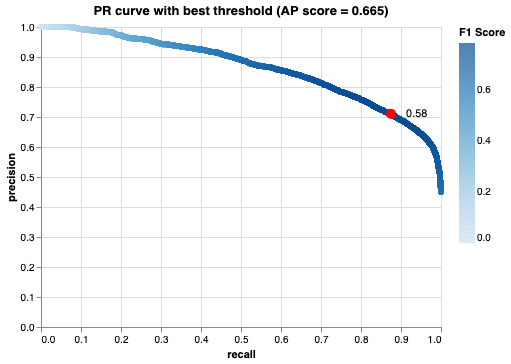

In [17]:
# PR curve with best threshold

PR_curve = alt.Chart(PR_curve_df).mark_circle().encode(
    x="recall",
    y="precision",
    color="F1 Score"
)
max_f1_point = alt.Chart(max_f1_df, 
                         title = 'PR curve with best threshold (AP score = 0.665)',).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="recall",
    y="precision"
)

text = max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("threshold", format = ".2f"))

PR_curve_plot = PR_curve + max_f1_point + text
PR_curve_plot

In [18]:
# Evaluate Model with test data set with best_thres
y_pred_train_thres = rand_search_rf.predict_proba(X_train)[:, 1] > best_thres
y_pred_thres = rand_search_rf.predict_proba(X_test)[:, 1] > best_thres

In [19]:
# Table of Metrics for positive class with best_thres
model_perf_thres_df = pd.DataFrame(
    {
        "Accuracy": [accuracy_score(y_train, y_pred_train_thres), accuracy_score(y_test, y_pred_thres)],
        "Precision": [precision_score(y_train, y_pred_train_thres), precision_score(y_test, y_pred_thres)],
        "Recall": [recall_score(y_train, y_pred_train_thres), recall_score(y_test, y_pred_thres)],
        "F1 Score": [f1_score(y_train, y_pred_train_thres), f1_score(y_test, y_pred_thres)]
    },
    index=["Train Data w/ best threshold", "Test Data w/ best threshold"])

In [20]:
model_perf_best_thres_df = pd.concat([model_perf_df, model_perf_thres_df])
model_perf_best_thres_df

,Accuracy,Precision,Recall,F1 Score
Train Data,0.868493,0.660388,0.934447,0.773870
Test Data,0.810577,0.571751,0.789392,0.663172
Train Data w/ best threshold,0.884094,0.710660,0.874888,0.784269
Test Data w/ best threshold,0.827652,0.615865,0.718669,0.663307


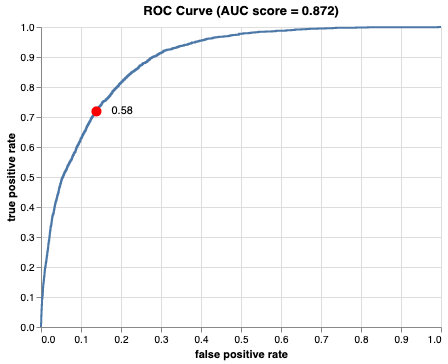

In [21]:
# # ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, rand_search_rf.predict_proba(X_test)[:, 1])

roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['thresholds'] = thresholds

pt_roc_idx = (roc_df['thresholds'] - best_thres).abs().argmin()

roc_curves = alt.Chart(roc_df, title = "ROC Curve (AUC score = 0.872)").mark_line().encode(
        alt.X('fpr', title="false positive rate"),
        alt.Y('tpr', title="true positive rate"))

roc_max_f1_point = alt.Chart(pd.DataFrame(roc_df.iloc[pt_roc_idx]).T, 
                         ).mark_circle(
    color="red", size=100, opacity=1).encode(
    x="fpr",
    y="tpr"
)

roc_text = roc_max_f1_point.mark_text(
    align='left',
    baseline='middle',
    dx=15).encode(text= alt.Text("thresholds:Q", format = ".2f"))

roc_curve_plot = roc_curves + roc_max_f1_point + roc_text
roc_curve_plot

In [22]:
# ROC_AUC score

roc_forest = roc_auc_score(y_test, pipe_forest.predict_proba(X_test)[:, 1])
print("AUC for Random Forest Classifier: {:.3f}".format(roc_forest))

AUC for Random Forest Classifier: 0.872
